# End - to - End Machine Learning Project

In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
#Function that downloads the dataset from the author's github repo
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    #Check If directory datasets is not yet created
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    #download the dataset using the URL which will be saved to a path
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

In [4]:
#Function to create a dataframe from reading the csv file
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Basic Information About the DataFrame

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing.shape

(20640, 10)

In [9]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Basic Plotting

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

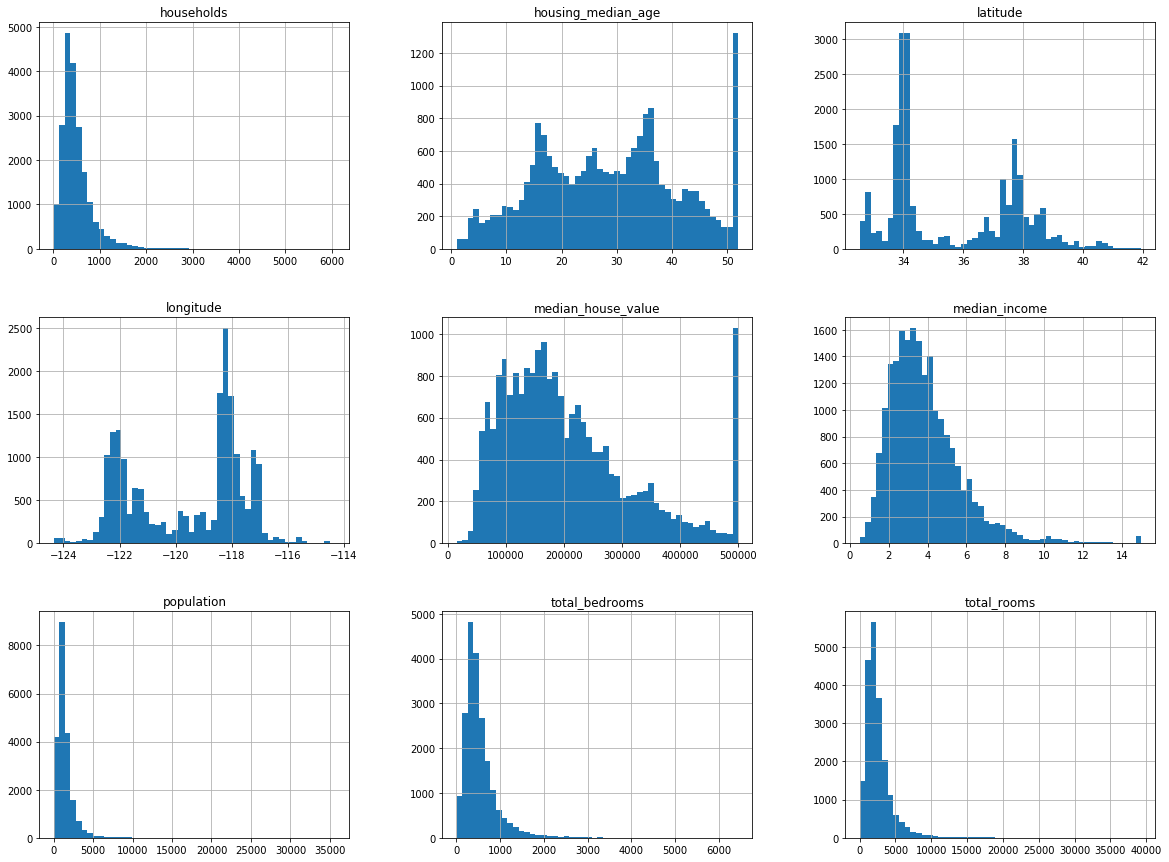

In [11]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Creating a Test

### Basic train-test-split

In [12]:
#Easiest way to create a train test split, but will result to overfit, due to shuffled_indices always changes every run,
#allowing the training model to see the data
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [66]:
split_train_test(housing, .2)[:2]

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 16058    -122.49     37.76                52.0       1792.0           305.0   
 17814    -121.82     37.42                13.0       3752.0           572.0   
 15737    -122.42     37.78                19.0       4065.0          1645.0   
 343      -122.19     37.75                36.0       1126.0           263.0   
 1539     -122.04     37.88                32.0       3250.0           550.0   
 10074    -120.10     39.33                 9.0       2738.0           510.0   
 7124     -118.03     33.90                36.0       1143.0           193.0   
 11208    -117.91     33.83                32.0       1855.0           527.0   
 5075     -118.31     33.98                52.0       1975.0           379.0   
 14176    -117.07     32.72                18.0       1758.0           286.0   
 19608    -121.12     37.48                 5.0       4109.0           820.0   
 4505     -118.20     34.05             

### Using hashing to identify test sets

>Using hashing we can identify the dataset, to ensure that we are not changing the train set everytime you run the functions

In [14]:
import hashlib

In [16]:
def test_set_check(identifier, test_ratio, hash):
    """
    @params:
    identifier: row id of the dataset
    test_ratio: percentage stated to be converted as test set
    hash: Hashing Algorithm
    """
    return hash(np.int64(identifier)).digest()[-1] < 256* test_ratio

In [67]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """
    @params
    data: holds dataset
    test_ration: percentage of the dataset to be turned into test set
    id_column: part of the dataset the holds unique values for each row
    hash: type of hashing to use
    """
    ids = data[id_column]
    
    #Apply a lambda function that checks the data for the test set, then returns the data separated
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [73]:
housing_with_id = housing.reset_index()

In [74]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [75]:
train_set.head(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY


### Creating a Test set using a more stable column

> Choosing which column to refernce your test set and training set is important. It ensures that when you needed to run the training algorithm again, you are properly and correctly choosing the correct training dataset and the correct test set

In [76]:
housing_with_id = housing.reset_index()

In [77]:
housing_with_id['id'] = housing['longitude']*1000+housing['latitude']

In [78]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [79]:
train_set[:10]

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,-122212.16
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,-122212.16
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,-122212.16
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY,-122232.15


### Creating test data using scikit learn train_test_split

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [83]:
train_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
17848,-121.86,37.42,20.0,5032.0,808.0,2695.0,801.0,6.6227,264800.0,<1H OCEAN
6252,-117.97,34.04,28.0,1686.0,417.0,1355.0,388.0,2.5192,157300.0,<1H OCEAN
9389,-122.53,37.91,37.0,2524.0,398.0,999.0,417.0,7.9892,500001.0,NEAR BAY
6113,-117.90,34.13,5.0,1126.0,316.0,819.0,311.0,1.5000,139800.0,<1H OCEAN
6061,-117.79,34.02,5.0,18690.0,2862.0,9427.0,2777.0,6.4266,315600.0,<1H OCEAN


### Fixing the Data

>median income is mostly at around $5000$ - $6000$, and within 4 - 6

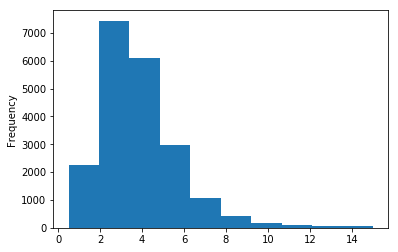

In [95]:
housing["median_income"].plot(kind='hist',)

In [89]:
housing["median_income"].head()

0    8.3252
1    8.3014
2    7.2574
3    5.6431
4    3.8462
Name: median_income, dtype: float64

In [90]:
#We are dividing the values of median_income by 1.5 then getting the ceiling value of that number is a float
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

In [91]:
#Converting all values of income_cat that are greater than 5 to be 5.
#We are adding a ceiling to the unique values inside the income_cat column
housing["income_cat"].where(housing["income_cat"] < 5,5.0, inplace=True)

In [92]:
housing["income_cat"][:10]

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
5    3.0
6    3.0
7    3.0
8    2.0
9    3.0
Name: income_cat, dtype: float64

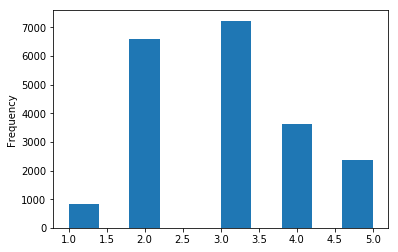

In [96]:
housing['income_cat'].plot(kind='hist')

### Sampling

In [98]:
from sklearn.model_selection import StratifiedShuffleSplit

In [99]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [101]:
strat_train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.0


In [102]:
strat_test_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3.0


In [103]:
#We get the percentage of each income_cat values and know how much does the dataset consist of that.
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

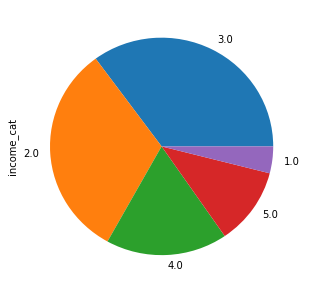

In [106]:
hs = housing['income_cat'].value_counts() / len(housing)
hs.plot(kind='pie',figsize=(5,5))

In [107]:
#Removing income_cat column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Plotting the Data

In [108]:
housing = strat_train_set.copy()

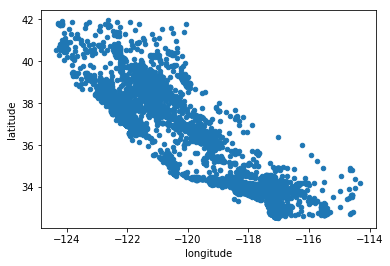

In [109]:
housing.plot(kind='scatter', x='longitude', y='latitude')

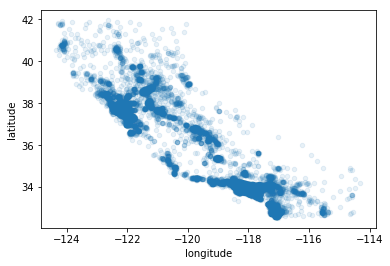

In [110]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

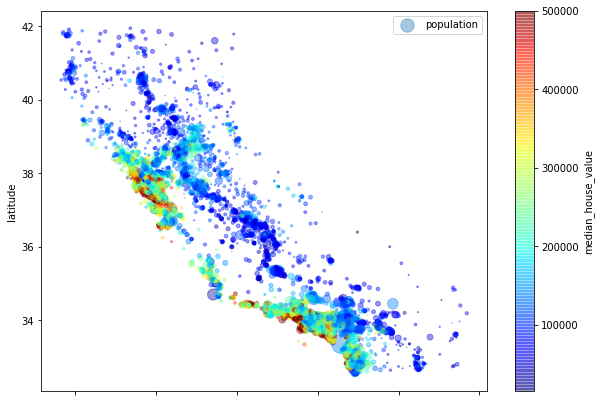

In [111]:
housing.plot(kind="scatter",
         x='longitude', 
            y='latitude',
            alpha=0.4,
            s=housing['population']/100, 
            label='population',
            figsize=(10,7),
            c="median_house_value",
            cmap=plt.get_cmap("jet"),
            colorbar=True
           )
plt.legend()

### Looking for correlations


In [113]:
corr_matrix = housing.corr()

In [114]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [115]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64